# How does the amount of classification data affect performance?

This notebook looks at how the number of labeled examples affects classification performance. The bacterial ensemble model will be used to initialize the classifier. The classifier produces robust test set performance with a small number of labeled examples. A classifier initialized with a pretrained language model trained on only 20 labeled examples achieves similar test set accuracy to a naive model (no pretraining) trained on over 6000 labeled examples.

In short, pretraining is extremely powerful.

![](media/data_reduction.png)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/e_coli/')
path_bact = Path('F:/genome/bacterial genomes/')

# Classification

In [5]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [6]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [7]:
train_df.shape

(6791, 9)

In [8]:
voc = np.load(path_bact/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

# Full Training Dataset (6791 Examples)

This is the training data copied from the E. coli 3 notebook.

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [40]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [15]:
learn.load_encoder('b2_enc')
learn.freeze()

In [16]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.299788,0.402819,0.906667
2,0.227257,0.322457,0.874667
3,0.196680,0.190672,0.928000


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.147245,0.103063,0.960000
2,0.123434,0.096796,0.970667
3,0.102523,0.098481,0.965333


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.069349,0.096312,0.972000
2,0.060054,0.089070,0.970667
3,0.051752,0.089726,0.969333


In [19]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.038490,0.084667,0.972000
2,0.037266,0.084177,0.977333
3,0.035116,0.089602,0.972000
4,0.032901,0.091328,0.970667
5,0.031205,0.090164,0.970667


In [20]:
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.027921,0.089311,0.970667
2,0.028479,0.090258,0.970667
3,0.026315,0.088215,0.973333
4,0.026514,0.086736,0.978667
5,0.025715,0.089114,0.970667


# Test

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.9734939759036144
False Positives: 0.00963855421686747
False Negatives: 0.016867469879518072
Recall: 0.9662650602409638
Precision: 0.980440097799511
MCC: 0.9470869412448478


# 3000 Examples

In [9]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(1500), train_df[train_df.Promoter == 0].sample(1500)])

In [10]:
train_small.shape

(3000, 9)

In [11]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [28]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [15]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [16]:
learn.load_encoder('b2_enc')
learn.freeze()

In [17]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.414335,0.620043,0.730667
2,0.303100,0.482333,0.862667
3,0.248520,0.366728,0.888000
4,0.217942,0.352245,0.890667
5,0.195392,0.284908,0.901333
6,0.173369,0.218856,0.921333


In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.113624,0.171081,0.930667
2,0.118288,0.130011,0.952000
3,0.110513,0.151421,0.938667
4,0.095867,0.114990,0.961333
5,0.081808,0.122089,0.961333
6,0.073963,0.118218,0.960000


In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.042519,0.115232,0.966667
2,0.036000,0.129753,0.964000
3,0.033787,0.147489,0.964000
4,0.032525,0.115737,0.970667
5,0.029225,0.104426,0.968000
6,0.027162,0.105847,0.968000


In [20]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.021656,0.105269,0.968000
2,0.019360,0.109552,0.968000
3,0.016506,0.109056,0.969333
4,0.016206,0.109944,0.968000
5,0.016908,0.111980,0.972000
6,0.017192,0.112317,0.972000


In [21]:
learn.fit_one_cycle(6, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.014346,0.112544,0.972000
2,0.012849,0.111694,0.972000
3,0.013318,0.111622,0.972000
4,0.012869,0.110362,0.972000
5,0.013659,0.110870,0.970667
6,0.014254,0.111812,0.970667


# Test

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.9662650602409638
False Positives: 0.012048192771084338
False Negatives: 0.021686746987951807
Recall: 0.9566265060240964
Precision: 0.9754299754299754
MCC: 0.932703436105461


# 1000 Examples

In [24]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(500), train_df[train_df.Promoter == 0].sample(500)])

In [25]:
train_small.shape

(1000, 9)

In [26]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [29]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [30]:
learn.load_encoder('b2_enc')
learn.freeze()

In [31]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.581923,0.681659,0.556000
2,0.432493,0.841863,0.500000
3,0.352054,0.697775,0.504000
4,0.305426,0.814644,0.500000
5,0.266110,0.755185,0.502667
6,0.240080,0.669226,0.514667


In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.142618,0.580151,0.600000
2,0.130938,0.461568,0.753333
3,0.117360,0.357306,0.904000
4,0.103678,0.325330,0.900000
5,0.093516,0.377807,0.830667
6,0.085439,0.341185,0.860000


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.061110,0.282645,0.901333
2,0.058245,0.262652,0.910667
3,0.047982,0.351937,0.833333
4,0.042817,0.309335,0.868000
5,0.038625,0.238903,0.905333
6,0.034842,0.203341,0.916000


In [34]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.025726,0.184142,0.926667
2,0.023061,0.168923,0.930667
3,0.022662,0.167027,0.934667
4,0.021540,0.163326,0.938667
5,0.021432,0.160265,0.941333
6,0.022690,0.157477,0.942667


In [35]:
learn.fit_one_cycle(6, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.013737,0.154943,0.944000
2,0.016709,0.154744,0.945333
3,0.016550,0.154012,0.945333
4,0.014476,0.151905,0.948000
5,0.015022,0.152138,0.945333
6,0.017516,0.155546,0.944000


# Test

In [36]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [37]:
get_scores(learn)

Accuracy: 0.9518072289156626
False Positives: 0.016867469879518072
False Negatives: 0.03132530120481928
Recall: 0.9373493975903614
Precision: 0.9652605459057072
MCC: 0.9039924579347985


# 500 Examples

In [38]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(250), train_df[train_df.Promoter == 0].sample(250)])

In [39]:
train_small.shape

(500, 9)

In [40]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [41]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [42]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [43]:
learn.load_encoder('b2_enc')
learn.freeze()

In [44]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.737392,0.692616,0.500000
2,0.682415,0.674011,0.566667
3,0.573828,0.677916,0.500000
4,0.514242,0.795978,0.500000
5,0.464291,0.865506,0.500000
6,0.425548,0.834359,0.500000


In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.252467,0.790540,0.500000
2,0.243036,0.735192,0.500000
3,0.214600,0.708398,0.500000
4,0.201674,0.691293,0.500000
5,0.187534,0.702691,0.500000
6,0.170622,0.694902,0.500000


In [46]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.093719,0.676649,0.500000
2,0.086459,0.715159,0.500000
3,0.080092,0.778921,0.500000
4,0.078080,0.827343,0.500000
5,0.072778,0.809337,0.500000
6,0.069272,0.776691,0.500000


In [47]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.092969,0.750223,0.500000
2,0.074871,0.704980,0.502667
3,0.068079,0.686442,0.505333
4,0.060616,0.664315,0.516000
5,0.059630,0.640910,0.524000
6,0.058205,0.616303,0.544000


In [48]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.041130,0.597104,0.556000
2,0.050762,0.578148,0.576000
3,0.059927,0.559793,0.617333
4,0.054771,0.539079,0.652000
5,0.053925,0.522051,0.673333
6,0.054797,0.506364,0.705333
7,0.051357,0.488721,0.737333
8,0.050220,0.470502,0.769333
9,0.051796,0.457204,0.780000
10,0.051996,0.439808,0.792000


In [49]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.061321,0.423521,0.814667
2,0.054007,0.410366,0.826667
3,0.052236,0.396131,0.840000
4,0.051457,0.381865,0.845333
5,0.050009,0.371135,0.854667
6,0.048366,0.361561,0.866667
7,0.048094,0.349306,0.873333
8,0.046913,0.337172,0.880000
9,0.048226,0.328518,0.882667
10,0.048259,0.316957,0.890667


In [50]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.039621,0.310975,0.892000
2,0.040390,0.304011,0.896000
3,0.036689,0.293311,0.898667
4,0.044617,0.285931,0.901333
5,0.043238,0.278124,0.905333
6,0.042105,0.270470,0.904000
7,0.045687,0.265021,0.904000
8,0.043736,0.259254,0.901333
9,0.044328,0.254428,0.900000
10,0.044461,0.249916,0.905333


# Test

In [51]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [52]:
get_scores(learn)

Accuracy: 0.9240963855421687
False Positives: 0.043373493975903614
False Negatives: 0.03253012048192771
Recall: 0.9349397590361446
Precision: 0.9150943396226415
MCC: 0.848392300357715


# 200 Examples

In [53]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(100), train_df[train_df.Promoter == 0].sample(100)])

In [54]:
train_small.shape

(200, 9)

In [55]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=150)

In [56]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [57]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [58]:
learn.load_encoder('b2_enc')
learn.freeze()

In [59]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.729342,0.694893,0.500000
2,0.671972,0.673174,0.866667
3,0.539558,0.661105,0.521333
4,0.461407,0.667665,0.501333
5,0.402259,0.672484,0.500000
6,0.363397,0.668363,0.501333


In [60]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.152879,0.664006,0.504000
2,0.155839,0.609188,0.681333
3,0.137422,0.578288,0.757333
4,0.117497,0.550154,0.821333
5,0.105734,0.531839,0.862667
6,0.096348,0.527279,0.853333


In [61]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.037408,0.525380,0.846667
2,0.036966,0.508491,0.860000
3,0.033586,0.493527,0.858667
4,0.028957,0.481982,0.864000
5,0.027698,0.473484,0.886667
6,0.027155,0.467202,0.881333


In [62]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.011544,0.461315,0.880000
2,0.021377,0.454619,0.876000
3,0.020670,0.450347,0.856000
4,0.018863,0.444369,0.854667
5,0.019108,0.438209,0.853333
6,0.019966,0.431631,0.853333


In [63]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.020053,0.423245,0.856000
2,0.016125,0.416298,0.857333
3,0.015539,0.409023,0.857333
4,0.014410,0.400869,0.862667
5,0.013911,0.393989,0.866667
6,0.013444,0.385033,0.873333
7,0.012615,0.378248,0.876000
8,0.016318,0.371274,0.881333
9,0.016071,0.365138,0.880000
10,0.015483,0.358483,0.882667


In [64]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.013605,0.351578,0.886667
2,0.014339,0.345472,0.886667
3,0.014928,0.340174,0.884000
4,0.017095,0.333473,0.886667
5,0.019899,0.327750,0.888000
6,0.018068,0.322249,0.888000
7,0.016736,0.316286,0.889333
8,0.017078,0.311065,0.894667
9,0.016391,0.306182,0.896000
10,0.016340,0.302339,0.896000


In [65]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.012889,0.298087,0.890667
2,0.014465,0.294121,0.890667
3,0.014244,0.290736,0.890667
4,0.014211,0.287022,0.892000
5,0.013514,0.283352,0.893333
6,0.012952,0.279653,0.894667
7,0.014451,0.276855,0.892000
8,0.013866,0.273511,0.892000
9,0.013678,0.270666,0.893333
10,0.014198,0.267756,0.893333


In [66]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.017743,0.265455,0.892000
2,0.013860,0.262414,0.892000
3,0.012962,0.258778,0.890667
4,0.014001,0.254729,0.894667
5,0.013443,0.250888,0.894667
6,0.013798,0.247505,0.896000
7,0.015389,0.245013,0.894667
8,0.014999,0.242425,0.898667
9,0.014701,0.239212,0.902667
10,0.015626,0.236619,0.902667


In [67]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.007793,0.234475,0.901333
2,0.007682,0.231785,0.906667
3,0.010036,0.230032,0.905333
4,0.009562,0.227298,0.905333
5,0.009753,0.224944,0.904000
6,0.009711,0.222461,0.904000
7,0.009631,0.220523,0.904000
8,0.010656,0.218762,0.904000
9,0.010652,0.216308,0.904000
10,0.011014,0.214295,0.904000


# Test

In [68]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=150)
learn.data = data_clas

In [69]:
get_scores(learn)

Accuracy: 0.9168674698795181
False Positives: 0.03734939759036145
False Negatives: 0.04578313253012048
Recall: 0.908433734939759
Precision: 0.9240196078431373
MCC: 0.8338535686789972


# 100 Examples

In [70]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(50), train_df[train_df.Promoter == 0].sample(50)])

In [71]:
train_small.shape

(100, 9)

In [73]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=50)

In [74]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [75]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [76]:
learn.load_encoder('b2_enc')
learn.freeze()

In [77]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.705879,0.689648,0.608000
2,0.538332,0.673370,0.500000
3,0.422999,0.720345,0.500000
4,0.345857,0.937343,0.500000
5,0.287855,0.985441,0.500000
6,0.254147,0.911552,0.500000


In [78]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.049932,0.877290,0.500000
2,0.052254,0.715135,0.512000
3,0.064414,0.689405,0.549333
4,0.066181,0.619399,0.592000
5,0.056240,0.595151,0.622667
6,0.048504,0.571634,0.650667


In [79]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.011844,0.572756,0.650667
2,0.015566,0.549681,0.682667
3,0.016612,0.465881,0.750667
4,0.020516,0.461149,0.757333
5,0.016985,0.431756,0.786667
6,0.014879,0.418276,0.797333


In [80]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.004916,0.410388,0.804000
2,0.004674,0.391112,0.814667
3,0.004418,0.377134,0.825333
4,0.006972,0.367866,0.830667
5,0.006954,0.358921,0.838667
6,0.006504,0.356272,0.842667


In [81]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.002737,0.352724,0.848000
2,0.005123,0.351893,0.850667
3,0.011910,0.349157,0.854667
4,0.016679,0.345262,0.858667
5,0.013885,0.341993,0.865333
6,0.017909,0.337748,0.866667
7,0.015518,0.335623,0.869333
8,0.015882,0.334578,0.872000
9,0.014172,0.331356,0.876000
10,0.012761,0.329570,0.877333


In [82]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.002407,0.324173,0.876000
2,0.012252,0.319098,0.882667
3,0.008523,0.314130,0.882667
4,0.006999,0.309498,0.886667
5,0.006033,0.305161,0.889333
6,0.005719,0.303557,0.892000
7,0.005223,0.299503,0.897333
8,0.005643,0.297896,0.900000
9,0.006492,0.297140,0.900000
10,0.006083,0.294580,0.904000


In [83]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.002675,0.293775,0.905333
2,0.006626,0.295097,0.904000
3,0.006712,0.294424,0.905333
4,0.006801,0.294760,0.904000
5,0.007443,0.293701,0.905333
6,0.013985,0.293698,0.905333
7,0.012012,0.294948,0.904000
8,0.010633,0.293279,0.906667
9,0.009463,0.292777,0.904000
10,0.008575,0.292731,0.905333


# Test

In [85]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=50)
learn.data = data_clas

In [86]:
get_scores(learn)

Accuracy: 0.9048192771084337
False Positives: 0.04216867469879518
False Negatives: 0.05301204819277108
Recall: 0.8939759036144578
Precision: 0.9137931034482759
MCC: 0.8098290139778188


# 50 Examples

In [87]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(25), train_df[train_df.Promoter == 0].sample(25)])

In [88]:
train_small.shape

(50, 9)

In [91]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=20)

You can deactivate this warning by passing `no_check=True`.


In [94]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [95]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [96]:
learn.load_encoder('b2_enc')
learn.freeze()

In [97]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.688060,0.691756,0.526667
2,0.500522,0.678133,0.509333
3,0.383007,0.770700,0.500000
4,0.317388,0.695855,0.500000
5,0.261195,0.651787,0.528000
6,0.224688,0.622606,0.740000


In [98]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.033607,0.612153,0.749333
2,0.168661,0.639843,0.606667
3,0.135291,0.634281,0.614667
4,0.113823,0.623421,0.664000
5,0.103403,0.604760,0.754667
6,0.089699,0.598067,0.748000


In [99]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.026742,0.588799,0.745333
2,0.026371,0.572405,0.768000
3,0.023629,0.570711,0.709333
4,0.021253,0.539750,0.740000
5,0.025934,0.515751,0.773333
6,0.022798,0.500776,0.790667


In [101]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.005912,0.486696,0.797333
2,0.007375,0.469053,0.812000
3,0.009182,0.451926,0.820000
4,0.007926,0.439188,0.829333
5,0.007645,0.430042,0.830667
6,0.007054,0.421522,0.832000


In [102]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.007266,0.413511,0.834667
2,0.006357,0.405961,0.836000
3,0.006267,0.397356,0.836000
4,0.005318,0.388775,0.829333
5,0.006813,0.380629,0.833333
6,0.006095,0.375244,0.834667
7,0.006577,0.366493,0.836000
8,0.010101,0.362805,0.840000
9,0.009657,0.360851,0.834667
10,0.009107,0.350443,0.844000


In [103]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.003567,0.342724,0.849333
2,0.004236,0.338702,0.853333
3,0.009557,0.334412,0.850667
4,0.008542,0.327510,0.856000
5,0.008534,0.325256,0.854667
6,0.009212,0.327938,0.852000
7,0.008448,0.320375,0.854667
8,0.009036,0.319649,0.854667
9,0.009147,0.322340,0.850667
10,0.009177,0.310433,0.853333


# Test

In [105]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=20)
learn.data = data_clas

You can deactivate this warning by passing `no_check=True`.


In [106]:
get_scores(learn)

Accuracy: 0.844578313253012
False Positives: 0.06144578313253012
False Negatives: 0.09397590361445783
Recall: 0.8120481927710843
Precision: 0.8685567010309279
MCC: 0.6906198163576734


# 20 Examples

In [107]:
train_small = pd.concat([train_df[train_df.Promoter == 1].sample(10), train_df[train_df.Promoter == 0].sample(10)])

In [108]:
train_small.shape

(20, 9)

In [110]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=10)

You can deactivate this warning by passing `no_check=True`.


In [111]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [112]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [113]:
learn.load_encoder('b2_enc')
learn.freeze()

In [114]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.685750,0.692575,0.500000
2,0.535729,0.684109,0.500000
3,0.448902,0.716836,0.500000
4,0.355097,0.726698,0.500000
5,0.303202,0.686418,0.500000
6,0.254032,0.666646,0.538667


In [115]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.045738,0.654896,0.658667
2,0.040444,0.673317,0.510667
3,0.038384,0.629174,0.616000
4,0.033354,0.615730,0.637333
5,0.029998,0.598907,0.694667
6,0.030934,0.589542,0.724000


In [116]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.006023,0.577124,0.742667
2,0.008903,0.551780,0.778667
3,0.008960,0.543426,0.782667
4,0.007778,0.542179,0.764000
5,0.008667,0.533239,0.770667
6,0.007753,0.525121,0.776000


In [117]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.015849,0.510953,0.788000
2,0.020823,0.496984,0.792000
3,0.014640,0.484036,0.798667
4,0.011050,0.474110,0.801333
5,0.009143,0.464092,0.801333
6,0.007757,0.457167,0.801333


In [118]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.007350,0.447985,0.808000
2,0.005791,0.439917,0.806667
3,0.004103,0.432002,0.802667
4,0.005649,0.425844,0.808000
5,0.007863,0.416546,0.804000
6,0.006607,0.409195,0.809333
7,0.005702,0.402664,0.808000
8,0.005087,0.394717,0.814667
9,0.004617,0.389080,0.812000
10,0.008662,0.380954,0.817333


In [119]:
learn.fit_one_cycle(10, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.000880,0.377723,0.825333
2,0.003262,0.377622,0.820000
3,0.004418,0.372519,0.822667
4,0.005398,0.367163,0.825333
5,0.004653,0.366183,0.824000
6,0.007763,0.360359,0.830667
7,0.006931,0.356955,0.836000
8,0.011706,0.353977,0.836000
9,0.011213,0.353111,0.838667
10,0.010950,0.352274,0.838667


# Test

In [121]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_small, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=10)
learn.data = data_clas

You can deactivate this warning by passing `no_check=True`.


In [122]:
get_scores(learn)

Accuracy: 0.8337349397590361
False Positives: 0.06144578313253012
False Negatives: 0.10481927710843374
Recall: 0.7903614457831325
Precision: 0.8654353562005277
MCC: 0.6699955113446165


In [124]:
exs = [6791, 3000, 1000, 500, 200, 100, 50, 20]
accs = [.973, .966, .951, .924, .916, .904, .844, .833]
recs = [.966, .956, .937, .934, .908, .893, .812, .790]
precs = [.98, .975, .965, .915, .924, .913, .868, .865]
MCCs = [.947, .932, .903, .848, .833, .809, .690, .669]

data_df = pd.DataFrame(exs, columns=['Examples'])
data_df['Accuracy'] = accs
data_df['Recall'] = recs
data_df['Precision'] = precs
data_df['Correlation Coefficient'] = MCCs

In [125]:
data_df

,Examples,Accuracy,Recall,Precision,Correlation Coefficient
0,6791,0.973,0.966,0.980,0.947
1,3000,0.966,0.956,0.975,0.932
2,1000,0.951,0.937,0.965,0.903
3,500,0.924,0.934,0.915,0.848
4,200,0.916,0.908,0.924,0.833
5,100,0.904,0.893,0.913,0.809
6,50,0.844,0.812,0.868,0.690
7,20,0.833,0.790,0.865,0.669


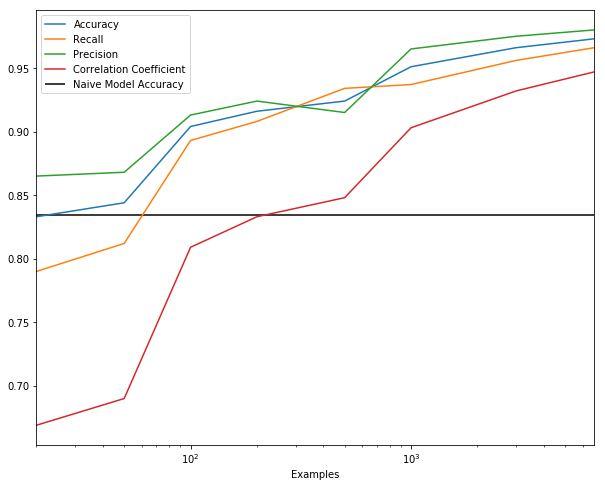

In [144]:
ax = data_df.plot(x='Examples', y=['Accuracy', 'Recall', 'Precision', 'Correlation Coefficient'], logx=True, figsize=(10,8))
xmin, xmax = ax.get_xlim()
ax.hlines(0.834, xmin, xmax, label='Naive Model Accuracy')
labels = ['Accuracy', 'Recall', 'Precision', 'Correlation Coefficient', 'Naive Model Accuracy']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels=labels);
ax.figure.savefig(path/'data_reduction.png')